In [6]:
%load_ext autoreload
%autoreload 2
from cgi import print_environ
from textwrap import indent
from read_files import *
from utils import utils
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import gensim
import numpy as np
import warnings
import pyLDAvis
import pyLDAvis.gensim_models

In [7]:
company = 'CIAT'

In [3]:
data = get_data("./in/" + company +"/")
new_stop = pd.read_csv('./in/stop_words.csv')
stop_words = stopwords.words('english')
stop_words.extend(new_stop['palabra'])

Leyendo documentos en: ingles
procesando Investigacion 33.txt
procesando Investigacion 27.txt
procesando Investigacion 26.txt
procesando Investigacion 32.txt
procesando investigacion 18.txt
procesando investigacion 24.txt
procesando Investigacion 30.txt
procesando Investigacion 31.txt
procesando Investigacion 25.txt
procesando investigacion 19.txt
procesando Investigacion 21.txt
procesando Investigacion 35.txt
procesando Investigacion 34.txt
procesando investigacion 20.txt
procesando Investigacion 36.txt
procesando Investigacion 22.txt
procesando Investigacion 23.txt
procesando Investigacion 37.txt
procesando Investigacion 50.txt
procesando Investigacion 44.txt
procesando Investigacion 45.txt
procesando Investigacion 51.txt
procesando Investigacion 47.txt
procesando Investigacion 53.txt
procesando Investigacion 9.txt
procesando Investigacion 8.txt
procesando Investigacion 52.txt
procesando Investigacion 46.txt
procesando Investigacion 42.txt
procesando Investigacion 56.txt
procesando I

In [8]:
data.head()

,document,idioma,file,clean_text
0,Scientific Fields of Interest: Environment; PG...,ingles,Investigacion 33.txt,"[scientific, field, interest, environment, pgr..."
1,Agriculture; Biology; Environment; Marine.\nMa...,ingles,Investigacion 27.txt,"[agriculture, biology, environment, marine, li..."
2,": Centrifuges, spectrophotometers, chromatogra...",ingles,Investigacion 26.txt,"[centrifuge, spectrophotometer, chromatography..."
3,Scientific Fields of Interest: Agriculture; Bi...,ingles,Investigacion 32.txt,"[scientific, field, interest, agriculture, bio..."
4,Several adoption models have been developed to...,ingles,investigacion 18.txt,"[several, adoption, model, developed, explain,..."


In [16]:
dictionary = gensim.corpora.Dictionary(data['clean_text'])
print('Antes de filtrar')
print(dictionary)
dictionary.filter_extremes(no_below=5,no_above=0.8)
print('Despues de filtrar')
print(dictionary)


Antes de filtrar
Dictionary<6167 unique tokens: ['acre', 'activity', 'agri', 'available', 'back']...>
Despues de filtrar
Dictionary<1120 unique tokens: ['available', 'back', 'bank', 'biodiversity', 'centre']...>


In [17]:
corpus = [dictionary.doc2bow(text) for text in data['clean_text']]

In [26]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=dictionary,
                                        num_topics=2, 
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        alpha=0.1,
                                        eta=0.2)

In [28]:
topicos = lda_model.print_topics(num_words=5, num_topics=2)
for topico in topicos:
    print(topico)

(0, '0.008*"climate" + 0.008*"project" + 0.007*"model" + 0.007*"program" + 0.006*"change"')
(1, '0.013*"plant" + 0.012*"technology" + 0.012*"farmer" + 0.010*"food" + 0.008*"production"')


In [29]:
my_dict = {'Topic_' + str(i): [token for token, score in lda_model.show_topic(i, topn=100)] for i in range(0, lda_model.num_topics)}


In [32]:
topics = pd.DataFrame.from_dict(my_dict)
topics.head()

,Topic_0,Topic_1
0,climate,plant
1,project,technology
2,model,farmer
3,program,food
4,change,production


In [36]:
topics.to_csv('topicosprueba.csv',index=False)

In [37]:
pd.read_csv('topicosprueba.csv')

,Topic_0,Topic_1
0,climate,plant
1,project,technology
2,model,farmer
3,program,food
4,change,production
...,...,...
95,significant,computer
96,asia,specie
97,big,environmental
98,review,animal


In [40]:
wordstopic = pd.read_csv("./out/" + company +"/" + 'wordsxtopic.csv')

In [41]:
wordstopic.head()


,Topic_0,Topic_1
0,climate,plant
1,project,technology
2,model,farmer
3,program,food
4,change,production


### procesamndo tesauros

In [43]:
tesauros = pd.read_excel('./in/plantilla_tesauros.xlsx')

In [51]:
tesauros

,Nom_Tesauro,Palabras
0,Cap_Difu,owl_Thing
1,Cap_Difu,Brochure
2,Cap_Difu,Certification
3,Cap_Difu,Implementation
4,Cap_Difu,Incubator
...,...,...
475,Cap_I,university_research
476,Cap_I,vaccine_development
477,Cap_I,volume_determination
478,Cap_I,Weight_determination


In [66]:
capacidades = tesauros['Nom_Tesauro'].unique().tolist()
capacidades

['Cap_Difu', 'Cap_Inves', 'Cap_I']

In [74]:
def split_tesauros(tesauros):
    xss =[x.split('_') for x in tesauros['Palabras']]
    flat_list = [x for xs in xss for x in xs] 
    tesauro = pd.DataFrame(flat_list,columns = ["Palabras"])
    tesauro['Palabras'] = tesauro['Palabras'].drop_duplicates()
    tesauro = tesauro[tesauro['Palabras'].notna()]
    return(tesauro)

In [75]:
def clean_tesauros(tesauros):
    list_cap = []
    for cap in capacidades:
        tesauro_cap = tesauros[tesauros['Nom_Tesauro']==cap]
        tesauro_cap = split_tesauros(tesauro_cap)
        tesauro_cap['Nom_tesauro'] = cap
        list_cap.append(tesauro_cap)
    return(pd.concat(list_cap))

In [78]:
tesauros = clean_tesauros(tesauros)

In [79]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

In [89]:
jaccard_similarity(topics['Topic_0'],tesauros[tesauros['Nom_tesauro']=='Cap_Difu']['Palabras'])

0.018292682926829267

In [91]:
{'Cap_Difu':[jaccard_similarity(topics[topic],tesauros[tesauros['Nom_tesauro']=='Cap_Difu']['Palabras']) for topic in topics.columns]}

{'Cap_Difu': [0.018292682926829267, 0.024539877300613498]}

In [97]:
dict_distancias = {}
for cap in capacidades:

    dict_distancias[cap]= [jaccard_similarity(topics[topic],tesauros[tesauros['Nom_tesauro']==cap]['Palabras']) for topic in topics.columns]

In [103]:
distancias = pd.DataFrame.from_dict(dict_distancias,orient='index',columns= wordstopic.columns)

In [113]:
distancias = distancias.reset_index()

In [114]:
distancias.columns

Index(['index', 'Topic_0', 'Topic_1'], dtype='object')

In [123]:
distancias

,index,Topic_0,Topic_1
0,Cap_Difu,0.018293,0.024540
1,Cap_Inves,0.056213,0.072072
2,Cap_I,0.057057,0.066667


In [116]:
distancias2 =  pd.melt(distancias,id_vars= 'index' ,value_vars=wordstopic.columns.tolist(), var_name= 'topico', value_name= 'distancia')

In [119]:
import seaborn as sns

In [120]:
distancias2

,index,topico,distancia
0,Cap_Difu,Topic_0,0.018293
1,Cap_Inves,Topic_0,0.056213
2,Cap_I,Topic_0,0.057057
3,Cap_Difu,Topic_1,0.024540
4,Cap_Inves,Topic_1,0.072072
5,Cap_I,Topic_1,0.066667


/Users/user/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/Users/user/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='topico', ylabel='distancia'>

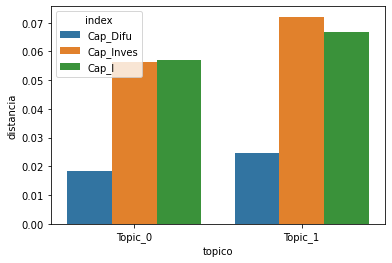

In [125]:
sns.barplot(x = 'topico', y= 'distancia', hue = 'index', data = distancias2)